In [23]:
import os, pathlib
import numpy as np
import neuropythy as ny
import matplotlib as mpl, matplotlib.pyplot as plt
import ipyvolume as ipv
import pandas as pd

from neuropythy.geometry.util import triangle_area

In [19]:
# The save directory where we load the ventral ROI labels from.
ventral_label_path = '~/code/hcp-annot-vc_data/save'

# The following code is for loading in the ventral ROI labels.
def load_ventral_pathaddr(rater, sid, h, lbl):
    p = pathlib.Path(ventral_label_path).expanduser()
    p = p / rater / str(sid)
    return ny.load(str(p / f"{h}.{lbl}_path.json.gz"))
def load_ventral_pathaddrs(rater, sid, h):
    rois = {}
    for k in ['hV4', 'VO1', 'VO2']:
        rois[k] = load_ventral_pathaddr(rater, sid, h, k)
    return rois
def load_ventral_paths(rater, sid, h):
    addrs = load_ventral_pathaddrs(rater, sid, h)
    hem = ny.data['hcp_lines'].subjects[sid].hemis[h]
    return {k: ny.geometry.Path(hem, path)
            for (k,path) in addrs.items()}
def load_ventral_labels(rater, sid, h):
    paths = load_ventral_paths(rater, sid, h)
    lbls = {}
    for (k,path) in paths.items():
        lbl = (path.label > 0.5)
        if np.sum(lbl) > np.sum(~lbl):
            lbl = ~lbl
        lbls[k] = lbl
    return lbls

In [25]:
# This is the sample rater and subject/hemisphere we will be using.
rater = 'lindazelinzhao'
sid = 102311
h = 'lh'

# Get the subject and hemisphere object, and the midgray surface.
sub = ny.data['hcp_lines'].subjects[sid]
hem = sub.hemis[h]
surf = hem.surface('midgray')

# Load the labels for visual areas and combine them.
ventral_labels = load_ventral_labels(rater, sid, h)
early_labels = {f'V{k}': hem.prop('visual_area') == k
                for k in [1,2,3]}
labels = dict(ventral_labels)
labels.update(early_labels)

In [35]:
surf.tess.faces

array([[     0,      4,      0, ..., 131647, 132557, 132992],
       [     1,      3,     50, ..., 132558, 132545, 132133],
       [     3,      1,     51, ..., 132123, 132544, 132558]])

In [36]:
(corner1, corner2, corner3) = surf.tess.faces

In [39]:
(vertex_x, vertex_y, vertex_z) = surf.coordinates

In [41]:
face0_a = corner1[0]
face0_b = corner1[1]
face0_c = corner1[2]

(vertex_x[face0_a], vertex_y[face0_a], vertex_z[face0_a])

(-14.739158, -97.410095, 8.203468)

In [56]:
corner_coords = surf.coordinates[:, surf.tess.faces]
corner_coords = np.transpose(corner_coords, (1,0,2))

In [57]:
corner_coords.shape

(3, 3, 273694)

In [59]:
# Get the coordinates for the first triangle:
# (a_xyz, b_xyz, c_xyz) = corner_coords[:,:,0]

(a, b, c) = corner_coords

In [77]:
face_areas = triangle_area(a, b, c)

In [78]:
face_areas

array([0.16524176, 0.20039554, 0.2609294 , ..., 0.2925599 , 0.29793352,
       0.85141593], dtype=float32)

In [83]:
vis_x = surf.prop('prf_x')
vis_y = surf.prop('prf_y')
vis_coords = np.array([vis_x, vis_y])

In [84]:
corner_vis_coords = vis_coords[:, surf.tess.faces]
corner_vis_coords = np.transpose(corner_vis_coords, (1,0,2))

In [85]:
corner_vis_coords.shape

(3, 2, 273694)

In [86]:
(vis_a, vis_b, vis_c) = corner_vis_coords

In [87]:
face_vis_areas = triangle_area(vis_a, vis_b, vis_c)

In [88]:
face_vis_areas.shape

(273694,)

/home/nben/.conda/envs/nben/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/nben/.conda/envs/nben/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([2.54057e+05, 2.26300e+03, 6.63000e+02, 3.77000e+02, 8.30000e+01,
        4.80000e+01, 2.10000e+01, 8.00000e+00, 1.00000e+01, 6.00000e+00]),
 array([  0.      ,  32.51551 ,  65.03102 ,  97.546524, 130.06204 ,
        162.57755 , 195.09305 , 227.60857 , 260.12408 , 292.6396  ,
        325.1551  ], dtype=float32),
 <a list of 10 Patch objects>)

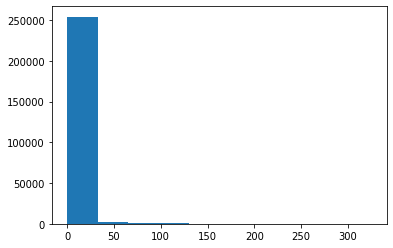

In [89]:
plt.hist(face_vis_areas)

In [91]:
cmag = face_areas / face_vis_areas

<ipython-input-91-3a105c3782d0>:1: RuntimeWarning: divide by zero encountered in true_divide
  cmag = face_areas / face_vis_areas


In [92]:
cmag

array([inf, inf, inf, ..., inf, inf, inf], dtype=float32)

(array([42308.,  2468.,  1594.,  1056.,   802.,   620.,   509.,   439.,
          344.,   302.]),
 array([2.2349953e-04, 4.9938625e+01, 9.9877029e+01, 1.4981543e+02,
        1.9975383e+02, 2.4969223e+02, 2.9963065e+02, 3.4956903e+02,
        3.9950745e+02, 4.4944583e+02, 4.9938425e+02], dtype=float32),
 <a list of 10 Patch objects>)

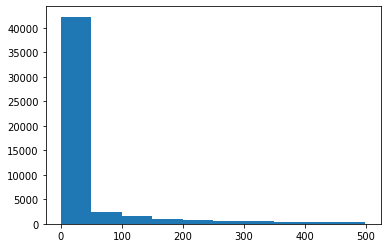

In [94]:
finite_cmag = cmag[np.isfinite(cmag)]
plt.hist(finite_cmag[finite_cmag < 500])